# CS 8321 Final Paper Code
- Author: Art Taychameekiatchai

In [1]:
import os
import sys
sys.path.append("..")

import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as GCNConv

from egg_models import egg_generic_losses
from egg_models.egg_generic import EggGeneric
from egg_models.egg_generic import EggGeneric
from functools import partial
from matplotlib.patches import ConnectionPatch
from scipy.stats import gaussian_kde, t
from utils import mutag_helper
from utils import visuals
import pygmtools as pygm
import networkx as nx

from egg_models.egg_generic_losses import activation_hook, dict_cos_dist, GEDasMatchLoss
from scipy.stats import stats


2024-05-04 18:57:23.473220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 18:57:40.978805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Simulation Study

In [2]:
def sample_graph_dist(n, min_nodes, max_nodes, 
                      cont_node_loc, cont_edge_loc, 
                      cont_node_sd, cont_edge_sd,
                      prob_X_d, prob_E_d, prob_A, 
                      cluster_lab):
    samples = []

    # Define feature distributions. 

    X_c_dist = td.Normal(cont_node_loc, cont_node_sd)
    E_c_dist = td.Normal(cont_edge_loc, cont_edge_sd) 
    X_d_dist = td.Bernoulli(prob_X_d)
    E_d_dist = td.Bernoulli(prob_E_d)
    A_dist = td.Bernoulli(prob_A)

    for i in range(n):
        # Sample the number of nodes from a discrete uniform.
        num_nodes = torch.randint(min_nodes, max_nodes, (1, )).item()

        # Sample the adjacency matrix.
        A = A_dist.sample(torch.Size([num_nodes, num_nodes]))
        A, _ = pyg.utils.dense_to_sparse(A)
        num_edges = A.shape[1]

        # Sample continuous features.
        X_c = X_c_dist.sample(torch.Size([num_nodes]))
        E_c = E_c_dist.sample(torch.Size([num_edges]))

        # Sample discrete_feature.
        X_d = X_d_dist.sample(torch.Size([num_nodes]))
        E_d = E_d_dist.sample(torch.Size([num_edges]))

        samples.append(
            pyg.data.Data(x = torch.stack((X_c, X_d), 1), 
                          edge_attr=torch.stack((E_c, E_d), 1), 
                          edge_index = A, y = cluster_lab)
        )

    return samples

class EdgeNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeNN, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, E):
        E = F.relu(self.fc1(E))
        E = self.dropout(E)
        E = F.relu(self.fc2(E))
        E = torch.mean(E, dim=0)

        return E

class NNConv(nn.Module):
    def __init__(self):
        super(NNConv, self).__init__()

        self.nnConv1 = pyg.nn.NNConv(in_channels=2, out_channels=10, 
            nn=EdgeNN(in_channels=2, out_channels=20), 
            aggr='mean', root_weight = True        
        )

        self.nnConv2 = pyg.nn.NNConv(in_channels=10, out_channels=5, 
            nn=EdgeNN(in_channels=2, out_channels=50), 
            aggr='mean', root_weight = True        
        )

        self.nnConv3 = pyg.nn.NNConv(in_channels=5, out_channels=2, 
            nn=EdgeNN(in_channels=2, out_channels=10), 
            aggr='mean', root_weight = True        
        )

    def forward(self, data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        x = self.nnConv1(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.nnConv2(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.nnConv3(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = pyg.nn.global_mean_pool(x, data.batch)
        return x

def train_embeddings(model, data_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(10):
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad() 

            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()

            optimizer.step()


def extract_avg_embeddings(model, data_loader):
    activation_names = ["nnConv1", "nnConv2"]
    train_avg_embedding_0 = {"nnConv1": [], "nnConv2": []}
    train_avg_embedding_1 = {"nnConv1": [], "nnConv2": []}
    pool_func = pyg.nn.global_mean_pool

    num_class_1 = 0
    num_class_0 = 0

    correct_1 = 0
    correct_0 = 0
    
    model.eval()

    for i, batch in enumerate(data_loader): 
        acts, remove_hooks = activation_hook(model, activation_names)
        pred_class = torch.argmax(model(batch), dim=1)
        remove_hooks()

        if batch.y.item() == 1:
            num_class_1 += 1

            for name in activation_names: 
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_1[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 1: 
                correct_1 += 1

        elif batch.y.item() == 0: 
            num_class_0 += 1

            for name in activation_names:
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_0[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 0: 
                correct_0 += 1

        assert batch.y.item() == 1 or batch.y.item() == 0

    acc_1 = correct_1 / num_class_1
    acc_0 = correct_0 / num_class_0

    print(f"Class 1 Accuracy: {acc_1} Class 0 Accuracy {acc_0}")

    for name in activation_names:
        train_avg_embedding_1[name] = torch.stack(
            train_avg_embedding_1[name]
        ).mean(dim=0)

        train_avg_embedding_0[name] = torch.stack(
            train_avg_embedding_0[name]
        ).mean(dim=0)

    return [train_avg_embedding_0, train_avg_embedding_1]

def get_embed_dist(model, data, avg_embeds):

    activation_names = ["nnConv1", "nnConv2"]
    distance = 0

    model.eval()
    loader = pyg.loader.DataLoader(data)

    for batch in loader: 
        acts, remove_hooks = activation_hook(model, activation_names)
        out = model(batch)
        remove_hooks()

        distance += (dict_cos_dist(
            acts, avg_embeds, batch.batch
        ) / 2).item()
    
    return distance / len(loader)

def extract_avg_embeddings_only_2(model, data_loader):
    activation_names = ["nnConv2"]
    train_avg_embedding_0 = {"nnConv2": []}
    train_avg_embedding_1 = {"nnConv2": []}
    pool_func = pyg.nn.global_mean_pool

    num_class_1 = 0
    num_class_0 = 0

    correct_1 = 0
    correct_0 = 0
    
    model.eval()

    for i, batch in enumerate(data_loader): 
        acts, remove_hooks = activation_hook(model, activation_names)
        pred_class = torch.argmax(model(batch), dim=1)
        remove_hooks()

        if batch.y.item() == 1:
            num_class_1 += 1

            for name in activation_names: 
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_1[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 1: 
                correct_1 += 1

        elif batch.y.item() == 0: 
            num_class_0 += 1

            for name in activation_names:
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_0[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 0: 
                correct_0 += 1

        assert batch.y.item() == 1 or batch.y.item() == 0

    acc_1 = correct_1 / num_class_1
    acc_0 = correct_0 / num_class_0

    print(f"Class 1 Accuracy: {acc_1} Class 0 Accuracy {acc_0}")

    for name in activation_names:
        train_avg_embedding_1[name] = torch.stack(
            train_avg_embedding_1[name]
        ).mean(dim=0)

        train_avg_embedding_0[name] = torch.stack(
            train_avg_embedding_0[name]
        ).mean(dim=0)

    return [train_avg_embedding_0, train_avg_embedding_1]

def get_embed_dist_only_2(model, data, avg_embeds):

    activation_names = ["nnConv2"]
    distance = 0

    model.eval()
    loader = pyg.loader.DataLoader(data)

    for batch in loader: 
        acts, remove_hooks = activation_hook(model, activation_names)
        out = model(batch)
        remove_hooks()

        distance += (dict_cos_dist(
            acts, avg_embeds, batch.batch
        ) / 2).item()
    
    return distance / len(loader)

def get_GED_between(data1, data2, ged_fn):
    avg_ged = 0
    for (graph_0, graph_1) in zip(data1, data2):

        # smaller graph first: 
        smaller = (
            (graph_1.x.shape[0] + graph_1.edge_index.shape[1]) < 
            (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        )
        if smaller:
            temp = graph_0
            graph_0 = graph_1
            graph_1 = temp 

        ged = ged_fn(
            graph_0.x.unsqueeze(0), graph_0.edge_index.unsqueeze(0), 
                graph_0.edge_attr.unsqueeze(0), 
            graph_1.x.unsqueeze(0), graph_1.edge_index.unsqueeze(0),
                graph_1.edge_attr.unsqueeze(0), 
        )

        avg_ged += (
            ged / (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        ).item()

    return avg_ged / len(data1)

def get_GED_within(data, GED_fn):

    avg_GED = 0
    for i in range(0, len(data), 2): 
        graph_0 = data[i]
        graph_1 = data[i + 1]

        # Smaller Graph First: 
        smaller = (
            (graph_1.x.shape[0] + graph_1.edge_index.shape[1]) < 
            (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        )
        if smaller:
            temp = graph_0
            graph_0 = graph_1
            graph_1 = temp 

        GED = GED_fn(
            graph_0.x.unsqueeze(0), graph_0.edge_index.unsqueeze(0), 
                graph_0.edge_attr.unsqueeze(0), 
            graph_1.x.unsqueeze(0), graph_1.edge_index.unsqueeze(0),
                graph_1.edge_attr.unsqueeze(0), 
        )

        avg_GED += (
            GED / (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        ).item()

    return avg_GED / (len(data) / 2)

def t_confidence_interval(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    n = len(data)
    t_value = t.ppf(0.975, df=n-1) 
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    lower_bound = np.round(mean - margin_of_error, 4)
    upper_bound = np.round(mean + margin_of_error, 4)

    print(f"({lower_bound}, {upper_bound})")

#### Simluation 1

In [4]:
# Parameters
c0_loc = -1
c1_loc = 1
c2_loc = 0

c0_n_min = 75
c0_n_max = 100

c1_n_min = 50
c1_n_max = 75

c2_n_min = 10
c2_n_max = 35

TRAINING_SAMPLES = 50
TESTING_SAMPLES = 50 # has to be even for paired comparisons.
TRIALS = 25

# Return lists
embed_within_0 = []
embed_between_01 = []
embed_between_02 = []

embed_within_1 = []
embed_between_10 = []
embed_between_12 = []

embed_within_0_only_2 = []
embed_between_01_only_2 = []
embed_between_02_only_2 = []

embed_within_1_only_2 = []
embed_between_10_only_2 = []
embed_between_12_only_2 = []

GED_within_0 = []
GED_within_1 = []

GED_between_01 = [] 

GED_between_02 = [] 
GED_between_12 = []

# Partial Functions
base_distribution = partial(sample_graph_dist, 
    cont_edge_loc=0, 
    cont_node_sd=1, cont_edge_sd=1, 
    prob_X_d=0.25, prob_E_d=0.25, 
    prob_A=1e-2
)

cluster_0_dist = partial(base_distribution, 
    cont_node_loc=c0_loc, cluster_lab=torch.tensor([0]), 
    min_nodes=c0_n_min, max_nodes=c0_n_max, 
    #prob_A = 5e-3
)

cluster_1_dist = partial(base_distribution, 
    cont_node_loc=c1_loc, cluster_lab=torch.tensor([1]), 
    min_nodes=c1_n_min, max_nodes=c1_n_max, 
    #prob_A = 1e-2
)

cluster_2_dist = partial(base_distribution, 
    cont_node_loc=c2_loc, cluster_lab=torch.tensor([2]), 
    min_nodes=c2_n_min, max_nodes=c2_n_max, 
    #prob_A = 1e-2
)

GED_fn = GEDasMatchLoss(
    1, (0, ), (1, ), (0, ), (1, )
)


for trial in range(TRIALS):
    c0_train = cluster_0_dist(n = TRAINING_SAMPLES)
    c1_train = cluster_1_dist(n = TRAINING_SAMPLES)

    train_data_loader = pyg.loader.DataLoader(
        c0_train + c1_train, shuffle=True
    )

    model = NNConv()

    train_embeddings(model, train_data_loader)

    avg_c0_embeds, avg_c1_embeds = extract_avg_embeddings(model, 
                                                          train_data_loader) 

    avg_c0_embeds_only_2, avg_c1_embeds_only_2 = extract_avg_embeddings_only_2(
        model, train_data_loader
    )

    c0_test = cluster_0_dist(n = TESTING_SAMPLES)
    c1_test = cluster_1_dist(n = TESTING_SAMPLES)
    c2 = cluster_2_dist(n = TESTING_SAMPLES)

    embed_within_0.append(get_embed_dist(model, c0_test, avg_c0_embeds))
    embed_within_1.append(get_embed_dist(model, c1_test, avg_c1_embeds))

    embed_between_01.append(get_embed_dist(model, c0_test, avg_c1_embeds))
    embed_between_10.append(get_embed_dist(model, c1_test, avg_c0_embeds))

    embed_between_02.append(get_embed_dist(model, c2, avg_c0_embeds))
    embed_between_12.append(get_embed_dist(model, c2, avg_c1_embeds))

    embed_within_0_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c0_embeds_only_2))
    embed_within_1_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c1_embeds_only_2))

    embed_between_01_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c1_embeds_only_2))
    embed_between_10_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c0_embeds_only_2))

    embed_between_02_only_2.append(get_embed_dist_only_2(model, c2, avg_c0_embeds_only_2))
    embed_between_12_only_2.append(get_embed_dist_only_2(model, c2, avg_c1_embeds_only_2))

    GED_within_0.append(get_GED_within(c0_test, GED_fn))
    GED_within_1.append(get_GED_within(c1_test, GED_fn))

    GED_between_01.append(get_GED_between(c0_test, c1_test, GED_fn))

    GED_between_02.append(get_GED_between(c0_test, c2, GED_fn))
    GED_between_12.append(get_GED_between(c1_test, c2, GED_fn))

lists_dict = {
    "embed_within_0": embed_within_0,
    "embed_between_01": embed_between_01,
    "embed_between_02": embed_between_02,
    "embed_within_1": embed_within_1,
    "embed_between_10": embed_between_10,
    "embed_between_12": embed_between_12,
    "embed_within_0_only_2": embed_within_0_only_2,
    "embed_between_01_only_2": embed_between_01_only_2,
    "embed_between_02_only_2": embed_between_02_only_2,
    "embed_within_1_only_2": embed_within_1_only_2,
    "embed_between_10_only_2": embed_between_10_only_2,
    "embed_between_12_only_2": embed_between_12_only_2,
    "GED_within_0": GED_within_0,
    "GED_within_1": GED_within_1,
    "GED_between_01": GED_between_01,
    "GED_between_02": GED_between_02,
    "GED_between_12": GED_between_12
}

for list_name in lists_dict:
    print(f"{list_name}: ")
    t_confidence_interval(lists_dict[list_name])
    print("\n")

Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Acc

#### Simulation 2

In [5]:
# Parameters
c0_loc = -1
c1_loc = 1
c2_loc = -5

c0_n_min = 75
c0_n_max = 100

c1_n_min = 50
c1_n_max = 75

c2_n_min = 10
c2_n_max = 35

TRAINING_SAMPLES = 50
TESTING_SAMPLES = 50 # has to be even for paired comparisons.
TRIALS = 50

# Return lists
embed_within_0 = []
embed_between_01 = []
embed_between_02 = []

embed_within_1 = []
embed_between_10 = []
embed_between_12 = []

embed_within_0_only_2 = []
embed_between_01_only_2 = []
embed_between_02_only_2 = []

embed_within_1_only_2 = []
embed_between_10_only_2 = []
embed_between_12_only_2 = []

GED_within_0 = []
GED_within_1 = []

GED_between_01 = [] 

GED_between_02 = [] 
GED_between_12 = []

# Partial Functions
base_distribution = partial(sample_graph_dist, 
    cont_edge_loc=0, 
    cont_node_sd=1, cont_edge_sd=1, 
    prob_X_d=0.25, prob_E_d=0.25, 
    prob_A=1e-2
)

cluster_0_dist = partial(base_distribution, 
    cont_node_loc=c0_loc, cluster_lab=torch.tensor([0]), 
    min_nodes=c0_n_min, max_nodes=c0_n_max, 
    # prob_A = 5e-3
)

cluster_1_dist = partial(base_distribution, 
    cont_node_loc=c1_loc, cluster_lab=torch.tensor([1]), 
    min_nodes=c1_n_min, max_nodes=c1_n_max, 
    # prob_A = 1e-2
)

cluster_2_dist = partial(base_distribution, 
    cont_node_loc=c2_loc, cluster_lab=torch.tensor([2]), 
    min_nodes=c2_n_min, max_nodes=c2_n_max, 
    # prob_A = 1e-2
)

GED_fn = GEDasMatchLoss(
    1, (0, ), (1, ), (0, ), (1, )
)


for trial in range(TRIALS):
    c0_train = cluster_0_dist(n = TRAINING_SAMPLES)
    c1_train = cluster_1_dist(n = TRAINING_SAMPLES)

    train_data_loader = pyg.loader.DataLoader(
        c0_train + c1_train, shuffle=True
    )

    model = NNConv()

    train_embeddings(model, train_data_loader)

    avg_c0_embeds, avg_c1_embeds = extract_avg_embeddings(model, 
                                                          train_data_loader) 

    avg_c0_embeds_only_2, avg_c1_embeds_only_2 = extract_avg_embeddings_only_2(
        model, train_data_loader
    )

    c0_test = cluster_0_dist(n = TESTING_SAMPLES)
    c1_test = cluster_1_dist(n = TESTING_SAMPLES)
    c2 = cluster_2_dist(n = TESTING_SAMPLES)

    embed_within_0.append(get_embed_dist(model, c0_test, avg_c0_embeds))
    embed_within_1.append(get_embed_dist(model, c1_test, avg_c1_embeds))

    embed_between_01.append(get_embed_dist(model, c0_test, avg_c1_embeds))
    embed_between_10.append(get_embed_dist(model, c1_test, avg_c0_embeds))

    embed_between_02.append(get_embed_dist(model, c2, avg_c0_embeds))
    embed_between_12.append(get_embed_dist(model, c2, avg_c1_embeds))

    embed_within_0_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c0_embeds_only_2))
    embed_within_1_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c1_embeds_only_2))

    embed_between_01_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c1_embeds_only_2))
    embed_between_10_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c0_embeds_only_2))

    embed_between_02_only_2.append(get_embed_dist_only_2(model, c2, avg_c0_embeds_only_2))
    embed_between_12_only_2.append(get_embed_dist_only_2(model, c2, avg_c1_embeds_only_2))

    GED_within_0.append(get_GED_within(c0_test, GED_fn))
    GED_within_1.append(get_GED_within(c1_test, GED_fn))

    GED_between_01.append(get_GED_between(c0_test, c1_test, GED_fn))

    GED_between_02.append(get_GED_between(c0_test, c2, GED_fn))
    GED_between_12.append(get_GED_between(c1_test, c2, GED_fn))

lists_dict = {
    "embed_within_0": embed_within_0,
    "embed_between_01": embed_between_01,
    "embed_between_02": embed_between_02,
    "embed_within_1": embed_within_1,
    "embed_between_10": embed_between_10,
    "embed_between_12": embed_between_12,
    "embed_within_0_only_2": embed_within_0_only_2,
    "embed_between_01_only_2": embed_between_01_only_2,
    "embed_between_02_only_2": embed_between_02_only_2,
    "embed_within_1_only_2": embed_within_1_only_2,
    "embed_between_10_only_2": embed_between_10_only_2,
    "embed_between_12_only_2": embed_between_12_only_2,
    "GED_within_0": GED_within_0,
    "GED_within_1": GED_within_1,
    "GED_between_01": GED_between_01,
    "GED_between_02": GED_between_02,
    "GED_between_12": GED_between_12
}

for list_name in lists_dict:
    print(f"{list_name}: ")
    t_confidence_interval(lists_dict[list_name])
    print("\n")

Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Accuracy: 1.0 Class 0 Accuracy 1.0
Class 1 Acc

### Training Generator Models

In [4]:
# fix random seeds for reproducibility.
SEED = 123123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True 
np.random.seed(SEED)

In [5]:
# Meta-Data
device = torch.device(0)    

node_types = ['C', 'N', 'O', 'F', "I", "Cl", 'Br']

edge_types = ['aromatic', 'single', 'double', 'triple']

color_palette = np.array(['orange', 'magenta', 'green', 'blue', 'cyan', 'red', 'lime'])

In [6]:
# Load explainee model.
explainee = mutag_helper.GCN2(hidden_channels=64, node_features=7, num_classes=2)
explainee.to(device)
explainee.load_state_dict(torch.load(
        "../data/explainees/MUTAG/gcn_200.pt", 
        map_location=device
    ), 
    strict=False
)
explainee.eval()

GCN2(
  (conv): GCN(7, 64, num_layers=3)
  (drop): Dropout(p=0, inplace=False)
  (lin): Linear(128, 64, bias=True)
  (out): Linear(64, 2, bias=True)
)

In [7]:
# Load cleaned datasets.
# See MUTAG.ipynb for code used to generate the data. 

base_path = "../data/explainees/MUTAG/"

with open(base_path + "MUTAG_train_data_list.pkl", "rb") as f:
    train_data_list = pickle.load(f)

with open(os.path.join(base_path, "MUTAG_train_data_list_1.pkl"), "rb") as f:
    train_data_list_1 = pickle.load(f)

with open(base_path + "MUTAG_train_data_list_0.pkl", "rb") as f:
    train_data_list_0 = pickle.load(f)

with open(base_path + "MUTAG_test_data_list.pkl", "rb") as f:
    test_data_list = pickle.load(f)

with open(base_path + "MUTAG_test_data_list_1.pkl", "rb") as f:
    test_data_list_1 = pickle.load(f)

with open(base_path + "MUTAG_test_data_list_0.pkl", "rb") as f:
    test_data_list_0 = pickle.load(f)

with open(base_path + "MUTAG_train_avg_embedding_dict_0.pkl", 'rb') as f: 
    avg_class_embedding_0 = pickle.load(f)

with open(base_path + "MUTAG_train_avg_embedding_dict_1.pkl", 'rb') as f: 
    avg_class_embedding_1 = pickle.load(f)

In [8]:
# Common Functions
max_node_size = 5
batch_size = 16
temp = 0.15

# L2
GED_fn = egg_generic_losses.GEDasMatchLoss(
    node_size=max_node_size, 
    cont_node_indices=None, 
    dis_node_indices=(slice(0, 6), ), 
    cont_edge_indices=None, 
    dis_edge_indices=(slice(0, 4), 4),
    cont_edit_weight=0.0, 
    dis_edit_weight=1.0,
)

In [9]:
# Compute Baseline Metrics - under random parameter initialization. 
runner = 0.0
for i in range(100):
    generator_untrained = EggGeneric(
        max_node_size=max_node_size,
        cont_node_feats=None, 
        dis_node_feats=(7, ), # num cats.
        cont_edge_feats=None, 
        dis_edge_feats=(4, ), # num cats.
        temp=temp, 
        batch_size=batch_size
    )
    generator_untrained.to(device)

    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_untrained())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner += pred.cpu().numpy()

print(f"Untrained Predicted Probability Means: {runner / 100}")

loader = pyg.loader.DataLoader(train_data_list_1, batch_size=batch_size, drop_last=True)
running_GED = 0
for batch in loader:
    generator_untrained = EggGeneric(
        max_node_size=max_node_size,
        cont_node_feats=None, 
        dis_node_feats=(7, ), # num cats.
        cont_edge_feats=None, 
        dis_edge_feats=(4, ), # num cats.
        temp=temp, 
        batch_size=batch_size
    )
    generator_untrained.to(device)

    batch.to(device)
    generated = generator_untrained()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED += loss.mean().item()

print(f"Untrained % Edit Distance to 1: {100 * running_GED / len(loader)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=batch_size, drop_last=True)
running_GED = 0
for batch in loader:
    generator_untrained = EggGeneric(
        max_node_size=max_node_size,
        cont_node_feats=None, 
        dis_node_feats=(7, ), # num cats.
        cont_edge_feats=None, 
        dis_edge_feats=(4, ), # num cats.
        temp=temp, 
        batch_size=batch_size
    )
    generator_untrained.to(device)

    batch.to(device)
    generated = generator_untrained()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED += loss.mean().item()

print(f"Untrained % Edit Distance to 0: {100 * running_GED / len(loader)}")

Untrained Predicted Probability Means: [0.8135047  0.18649518]
Untrained % Edit Distance to 1: 24.097028623024624
Untrained % Edit Distance to 0: 22.777141133944195


In [10]:
# Train generator targeting class 1. 
target = torch.tensor([0.0, 1.0]) # t

generator_1 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    temp=temp, 
    batch_size=batch_size
)
generator_1.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)

loader = pyg.loader.DataLoader(train_data_list + test_data_list, 
                               batch_size=batch_size, drop_last=True)

optimizer = torch.optim.RMSprop(generator_1.parameters())  

num_epochs = 25
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_1()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1.0 * loss_1 # Lambda_1

        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (explainee_pred @ 
                target.to(explainee_pred.device) - 0.5
            )

            egg_size = (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg) / egg_size # / (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L3. 
        loss_3 = 1.0 * omega * loss_2 # Lambda_2
         
        loss = loss_1 + loss_3

        loss = loss.mean()

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_1.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")

Epoch 0: Loss: 0.9381139982830394
Epoch 1: Loss: 0.7963677265427329
Epoch 2: Loss: 0.6625947247851979
Epoch 3: Loss: 0.6103986312042583
Epoch 4: Loss: 0.5416127199476416
Epoch 5: Loss: 0.5208865214477886
Epoch 6: Loss: 0.5318739305843007
Epoch 7: Loss: 0.46936979348009283
Epoch 8: Loss: 0.4795293564146215
Epoch 9: Loss: 0.49122524532404815
Epoch 10: Loss: 0.42994523319331085
Epoch 11: Loss: 0.4425692477009513
Epoch 12: Loss: 0.4308392893184315
Epoch 13: Loss: 0.4030413573438471
Epoch 14: Loss: 0.400194834579121
Epoch 15: Loss: 0.3823706968264146
Epoch 16: Loss: 0.35924877632748
Epoch 17: Loss: 0.34833439913662995
Epoch 18: Loss: 0.371945551850579
Epoch 19: Loss: 0.3664377385919744
Epoch 20: Loss: 0.38441203940998425
Epoch 21: Loss: 0.35724840380928735
Epoch 22: Loss: 0.3495248014276678
Epoch 23: Loss: 0.36101478338241577
Epoch 24: Loss: 0.3604459112340754


In [11]:
# Check mean prediction.
runner = []
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_1())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner.append(pred[1].item())

t_confidence_interval(runner)

(0.9755, 0.9873)


In [12]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_1()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 1: {t_confidence_interval(100 * running_GED)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_1()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f" % Edit Distance to 0: {t_confidence_interval(100 * running_GED)}")

(0.2352, 0.2373)
% Edit Distance to 1: None
(0.232, 0.2342)
 % Edit Distance to 0: None


In [13]:
# Train generator targeting class 0. 

target = torch.tensor([1.0, 0.0]) # t

generator_0 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    temp=temp, 
    batch_size=batch_size
)
generator_0.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)

loader = pyg.loader.DataLoader(train_data_list + test_data_list, 
                               batch_size=batch_size, drop_last=True)

optimizer = torch.optim.RMSprop(generator_0.parameters())  

num_epochs = 25
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_0()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1.0 * loss_1 # lambda_1

        # Compute omega.
        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (explainee_pred @ 
                target.to(explainee_pred.device) - 0.5
            )
            egg_size = (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg) / egg_size # / (gen_egg[0].shape[1] + gen_egg[2].shape[1]) 

        # Compute L3. 
        loss_3 = 1.0 * omega * loss_2 # lambda_2

        loss = loss_1 + loss_3

        loss = loss.mean()

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_0.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()
    
    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")

Epoch 0: Loss: 0.4576905478130687
Epoch 1: Loss: 0.4027106220071966
Epoch 2: Loss: 0.374257892370224
Epoch 3: Loss: 0.3489954417402094
Epoch 4: Loss: 0.36678438024087384
Epoch 5: Loss: 0.34194112636826257
Epoch 6: Loss: 0.3208999999544837
Epoch 7: Loss: 0.3210139951922677
Epoch 8: Loss: 0.351883281360973
Epoch 9: Loss: 0.31029493700374255
Epoch 10: Loss: 0.3364894579757344
Epoch 11: Loss: 0.35117127136750653
Epoch 12: Loss: 0.32591427998109296
Epoch 13: Loss: 0.3226977410641583
Epoch 14: Loss: 0.33153157342563977
Epoch 15: Loss: 0.30374539440328424
Epoch 16: Loss: 0.3046424673362212
Epoch 17: Loss: 0.2895800606770949
Epoch 18: Loss: 0.2899319285696203
Epoch 19: Loss: 0.30207412622191687
Epoch 20: Loss: 0.2906195589087226
Epoch 21: Loss: 0.3252750337123871
Epoch 22: Loss: 0.33515145832842047
Epoch 23: Loss: 0.28955985605716705
Epoch 24: Loss: 0.30636881020936096


In [14]:
# Check mean prediction
runner = []
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_0())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner.append(pred[0].item())

t_confidence_interval(runner)

(0.9735, 0.9863)


In [15]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_0()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 1")
t_confidence_interval(100 * running_GED)

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_0()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 0")
t_confidence_interval(100 * running_GED)

% Edit Distance to 1
(0.2849, 0.2871)
% Edit Distance to 0
(0.2924, 0.2962)


### Figures

Text(0.5, 1.0, 'GED: 0.28')

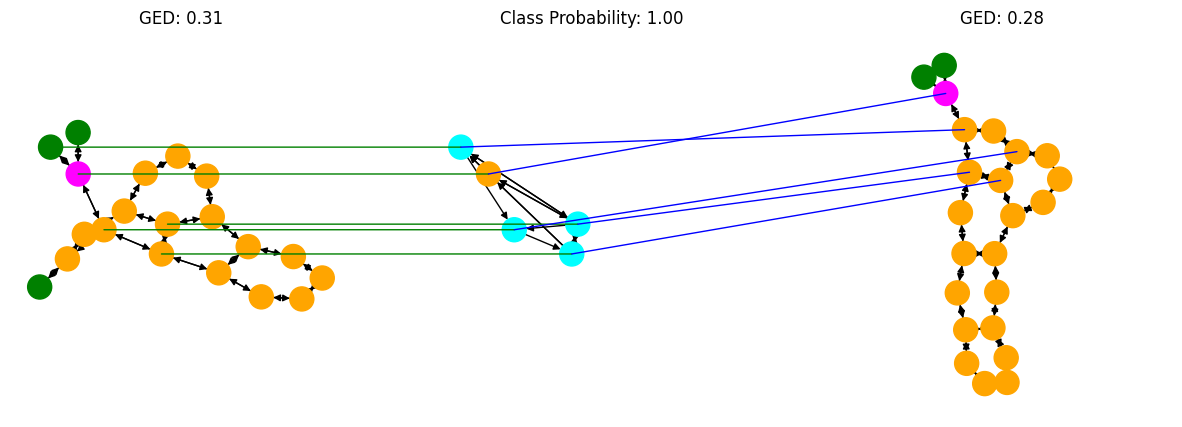

In [52]:
# Set to single batch for visualizations. 
generator_trained_1 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    temp=temp, 
    batch_size=1
)
generator_trained_1.load_state_dict(generator_1.state_dict())

gen = generator_trained_1()
gen_ex = mutag_helper.egg_to_ex(gen)
gen_egg = mutag_helper.egg_to_egg(gen)
colors0 = color_palette[torch.argmax(gen_ex.x, dim=-1).numpy()]
gen_nx = pyg.utils.to_networkx(gen_ex)
#nx.draw(gen_nx, node_color = colors)

obs_ex = test_data_list_1[5]
obs_egg = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex]))
colors1 = color_palette[torch.argmax(obs_ex.x, dim=-1).numpy()]
obs_nx = pyg.utils.to_networkx(obs_ex)
#nx.draw(obs_nx, node_color = colors)

obs_ex2 = test_data_list_1[0]
obs_egg2 = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex2]))
colors2 = color_palette[torch.argmax(obs_ex2.x, dim=-1).numpy()]
obs_nx2 = pyg.utils.to_networkx(obs_ex2)

with torch.no_grad():
    aff_mat = GED_fn.get_aff_mat(*gen_egg, *obs_egg)
    dis_match_mat = GED_fn.get_dis_match_mat(aff_mat)

with torch.no_grad():
    aff_mat2 = GED_fn.get_aff_mat(*gen_egg, *obs_egg2)
    dis_match_mat2 = GED_fn.get_dis_match_mat(aff_mat2)

GED_score = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat, aff_mat) / 
    (gen_egg[0].shape[1] + gen_egg[2].shape[1])
).item()
pred_score = torch.softmax(explainee(gen_ex.to(device)), dim=-1)[:, 1].item()
gen_ex.cpu()

GED_score2 = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat2, aff_mat2) / 
    (gen_egg[0].shape[1] + gen_egg[2].shape[1]) 
).item()

pos_1 = nx.spring_layout(obs_nx)
# pos_2 = nx.spring_layout(gen_nx)
pos_2 = {}
for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    pos_2[i] = pos_1[j]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

nx.draw(obs_nx, node_color = colors1, pos = pos_1, ax=axes[0])

nx.draw(gen_nx, node_color = colors0, pos=pos_2, ax=axes[1])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_2[i], xyB=pos_1[j], 
                        coordsA="data", coordsB="data",
                        axesA=axes[0], axesB=axes[1], color="green")

    fig.add_artist(con)

pos_3 = nx.spring_layout(obs_nx2)
# for i in range(gen_ex.x.shape[0]):
#     j = torch.argmax(dis_match_mat.squeeze()[i]).item()
#     pos_3[j] = pos_2[i]

nx.draw(obs_nx2, node_color = colors2, pos = pos_3, ax=axes[2])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat2.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_3[j], xyB=pos_2[i], 
                        coordsA="data", coordsB="data",
                        axesA=axes[2], axesB=axes[1], color="blue")

    fig.add_artist(con)

axes[0].set_title(f"GED: {GED_score:0.2f}")
axes[1].set_title(f"Class Probability: {pred_score:0.2f}")
axes[2].set_title(f"GED: {GED_score2:0.2f}")

Text(0.5, 1.0, 'GED: 0.22')

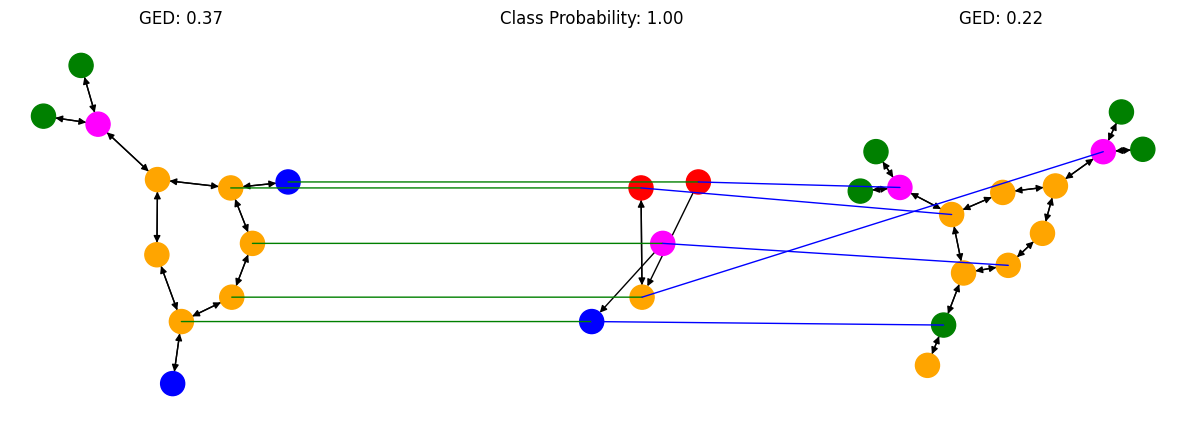

In [58]:
# Set to single batch for visualizations. 
generator_trained_0 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=1
)
generator_trained_0.load_state_dict(generator_0.state_dict())

gen = generator_trained_0()
gen_ex = mutag_helper.egg_to_ex(gen)
gen_egg = mutag_helper.egg_to_egg(gen)
colors0 = color_palette[torch.argmax(gen_ex.x, dim=-1).numpy()]
gen_nx = pyg.utils.to_networkx(gen_ex)
#nx.draw(gen_nx, node_color = colors)

obs_ex = test_data_list_0[5]
obs_egg = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex]))
colors1 = color_palette[torch.argmax(obs_ex.x, dim=-1).numpy()]
obs_nx = pyg.utils.to_networkx(obs_ex)
#nx.draw(obs_nx, node_color = colors)

obs_ex2 = test_data_list_0[1]
obs_egg2 = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex2]))
colors2 = color_palette[torch.argmax(obs_ex2.x, dim=-1).numpy()]
obs_nx2 = pyg.utils.to_networkx(obs_ex2)

with torch.no_grad():
    aff_mat = GED_fn.get_aff_mat(*gen_egg, *obs_egg)
    dis_match_mat = GED_fn.get_dis_match_mat(aff_mat)

with torch.no_grad():
    aff_mat2 = GED_fn.get_aff_mat(*gen_egg, *obs_egg2)
    dis_match_mat2 = GED_fn.get_dis_match_mat(aff_mat2)

GED_score = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat, aff_mat) / 
    (gen_egg[0].shape[1] + gen_egg[2].shape[1])
).item()
pred_score = torch.softmax(explainee(gen_ex.to(device)), dim=-1)[:, 0].item()
gen_ex.cpu()

GED_score2 = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat2, aff_mat2) / 
    (gen_egg[0].shape[1] + gen_egg[2].shape[1])
).item()

pos_1 = nx.spring_layout(obs_nx)
# pos_2 = nx.spring_layout(gen_nx)
pos_2 = {}
for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    pos_2[i] = pos_1[j]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

nx.draw(obs_nx, node_color = colors1, pos = pos_1, ax=axes[0])

nx.draw(gen_nx, node_color = colors0, pos=pos_2, ax=axes[1])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_2[i], xyB=pos_1[j], 
                        coordsA="data", coordsB="data",
                        axesA=axes[0], axesB=axes[1], color="green")

    fig.add_artist(con)

pos_3 = nx.spring_layout(obs_nx2)
# for i in range(gen_ex.x.shape[0]):
#     j = torch.argmax(dis_match_mat.squeeze()[i]).item()
#     pos_3[j] = pos_2[i]

nx.draw(obs_nx2, node_color = colors2, pos = pos_3, ax=axes[2])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat2.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_3[j], xyB=pos_2[i], 
                        coordsA="data", coordsB="data",
                        axesA=axes[2], axesB=axes[1], color="blue")

    fig.add_artist(con)

axes[0].set_title(f"GED: {GED_score:0.2f}")
axes[1].set_title(f"Class Probability: {pred_score:0.2f}")
axes[2].set_title(f"GED: {GED_score2:0.2f}")

- Based on theses few examples, the model looks for groups of yellow node on the outside of the molecule. Typically, having to identify multiple groups to be confident in the predictions. This checks out with the heuristics in the literature that multiple N02 group indicate mutagenic molecules. 

- In contrast the model primarily looks at the rings to determine non-mutagenic molecules. It is possible that the model is also flagging a single NO2 group as evidence. 

- The first example might actually expose a flaw in the explainee model as a graph of pure purple nodes in confidently classified as mutagenic.  

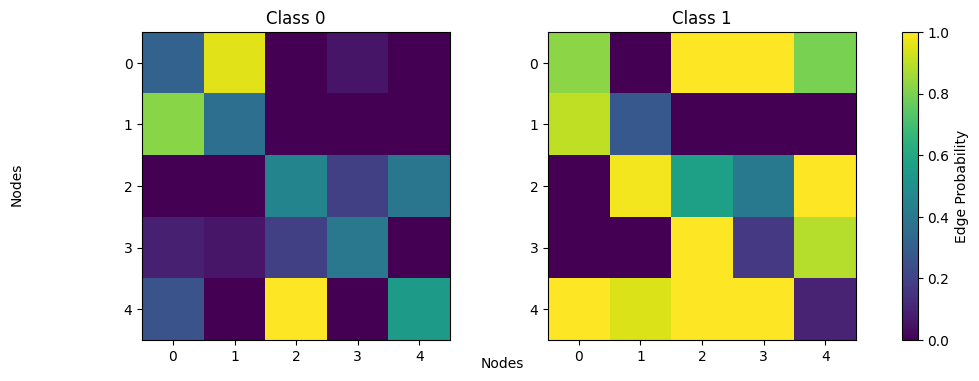

In [36]:
edge_probs_0 = generator_trained_0.AdjacencyMatrix.probs
edge_probs_0 = edge_probs_0.detach().cpu().numpy()

edge_probs_1 = generator_trained_1.AdjacencyMatrix.probs
edge_probs_1 = edge_probs_1.detach().cpu().numpy()

# edge_probs_untrained = generator_untrained.AdjacencyMatrix.probs
# edge_probs_untrained = edge_probs_untrained.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(edge_probs_0, cmap='viridis', interpolation='nearest')
im1 = axes[1].imshow(edge_probs_1, cmap='viridis', interpolation='nearest')
#im2 = axes[2].imshow(edge_probs_untrained, cmap='viridis', interpolation='nearest')

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes.ravel().tolist())
cbar.set_label('Edge Probability')

# Set titles
axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
# axes[2].set_title('Untrained')

# Set common x and y labels
fig.text(0.45, 0.04, 'Nodes', ha='center')
fig.text(0.04, 0.5, 'Nodes', va='center', rotation='vertical')

plt.show()

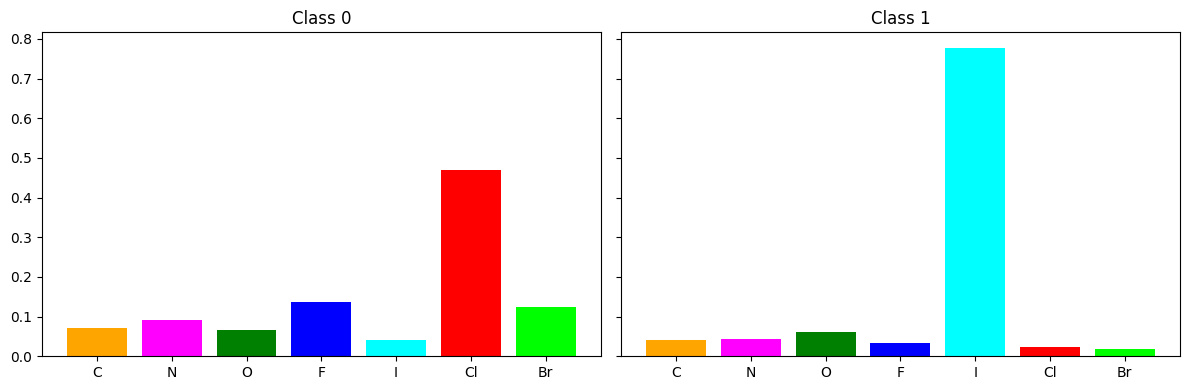

In [59]:
cell_type_probs_0 = torch.softmax(generator_trained_0.DisNodeFeats[0].probs, dim=0)
cell_type_probs_0 = cell_type_probs_0.detach().cpu().numpy()

cell_type_probs_1 = torch.softmax(generator_trained_1.DisNodeFeats[0].probs, dim=0)
cell_type_probs_1 = cell_type_probs_1.detach().cpu().numpy()

cell_type_probs_untrained = torch.softmax(
    generator_untrained.DisNodeFeats[0].probs, dim=0)
cell_type_probs_untrained = cell_type_probs_untrained.detach().cpu().numpy()

plot_indices = node_types

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(plot_indices, cell_type_probs_0, color=color_palette)
axes[1].bar(plot_indices, cell_type_probs_1, color=color_palette)
#axes[2].bar(plot_indices, cell_type_probs_untrained, color=color_palette)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
#axes[2].set_title('Untrained')

plt.tight_layout()
plt.show()


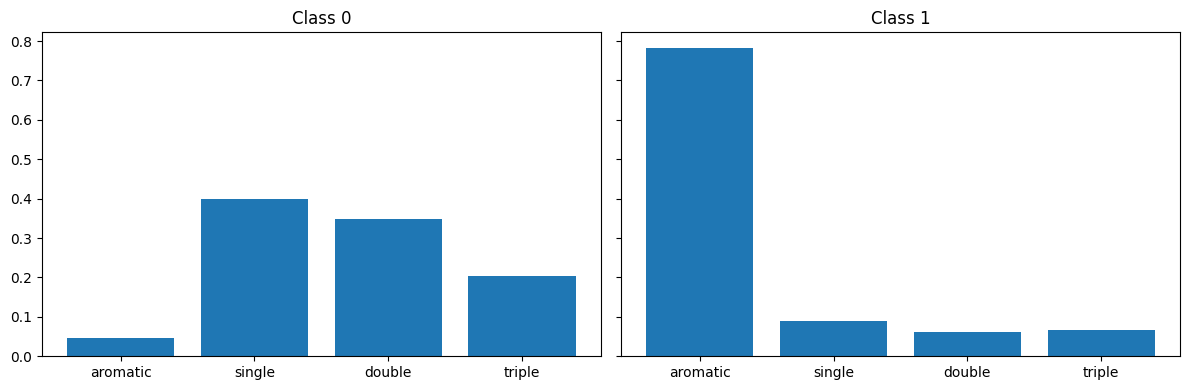

In [20]:
cell_type_probs_0 = torch.softmax(generator_trained_0.DisEdgeFeats[0].probs, dim=0)
cell_type_probs_0 = cell_type_probs_0.detach().cpu().numpy()

cell_type_probs_1 = torch.softmax(generator_trained_1.DisEdgeFeats[0].probs, dim=0)
cell_type_probs_1 = cell_type_probs_1.detach().cpu().numpy()

# cell_type_probs_untrained = torch.softmax(
#     generator_untrained.DisEdgeFeats[0].probs, dim=0)
# cell_type_probs_untrained = cell_type_probs_untrained.detach().cpu().numpy()

plot_indices = edge_types

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(plot_indices, cell_type_probs_0)
axes[1].bar(plot_indices, cell_type_probs_1)
#axes[2].bar(plot_indices, cell_type_probs_untrained)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
#axes[2].set_title('Untrained')

plt.tight_layout()
plt.show()

## Without GED

In [21]:
# Train generator targeting class 1. 
target = torch.tensor([0.0, 1.0]) # t

generator_1_no_GED = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    temp=temp, 
    batch_size=batch_size
)
generator_1_no_GED.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)

loader = pyg.loader.DataLoader(train_data_list + test_data_list, 
                               batch_size=batch_size, drop_last=True)

optimizer = torch.optim.RMSprop(generator_1_no_GED.parameters())  

num_epochs = 25
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_1_no_GED()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1.0 * loss_1 # Lambda_1

        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (explainee_pred @ 
                target.to(explainee_pred.device) - 0.5
            )

            egg_size = (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg) / egg_size # / (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L3. 
        loss_3 = 0.0 * omega * loss_2 # Lambda_2
         
        loss = loss_1 + loss_3

        loss = loss.mean()

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_1_no_GED.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")

Epoch 0: Loss: 1.0528838580304927
Epoch 1: Loss: 0.952051655812697
Epoch 2: Loss: 0.8398000001907349
Epoch 3: Loss: 0.7674435106190768
Epoch 4: Loss: 0.7206683321432634
Epoch 5: Loss: 0.593292006037452
Epoch 6: Loss: 0.6248630718751387
Epoch 7: Loss: 0.5924959562041543
Epoch 8: Loss: 0.5464394769885323
Epoch 9: Loss: 0.5535937439311635
Epoch 10: Loss: 0.5411829406564886
Epoch 11: Loss: 0.55226684700359
Epoch 12: Loss: 0.46649107336997986
Epoch 13: Loss: 0.49167903986844147
Epoch 14: Loss: 0.44398960200223053
Epoch 15: Loss: 0.4442921551791104
Epoch 16: Loss: 0.42168246886946936
Epoch 17: Loss: 0.4624792825091969
Epoch 18: Loss: 0.4163932664827867
Epoch 19: Loss: 0.4146206947890195
Epoch 20: Loss: 0.402875000780279
Epoch 21: Loss: 0.3823788193139163
Epoch 22: Loss: 0.4006255567073822
Epoch 23: Loss: 0.3937156173315915
Epoch 24: Loss: 0.39290060238404706


In [22]:
# Check mean prediction
runner = []
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_1_no_GED())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner.append(pred[1].item())

t_confidence_interval(runner)

(0.9167, 0.9405)


In [23]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_1_no_GED()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 1: {t_confidence_interval(100 * running_GED)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_1_no_GED()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f" % Edit Distance to 0: {t_confidence_interval(100 * running_GED)}")

(0.256, 0.2585)
% Edit Distance to 1: None
(0.2751, 0.2785)
 % Edit Distance to 0: None


In [24]:
# Train generator targeting class 0. 

target = torch.tensor([1.0, 0.0]) # t

generator_0_no_GED = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    temp=temp, 
    batch_size=batch_size
)
generator_0_no_GED.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)

loader = pyg.loader.DataLoader(train_data_list + test_data_list, 
                               batch_size=batch_size, drop_last=True)

optimizer = torch.optim.RMSprop(generator_0_no_GED.parameters())  

num_epochs = 25
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_0_no_GED()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1.0 * loss_1 # lambda_1

        # Compute omega.
        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (explainee_pred @ 
                target.to(explainee_pred.device) - 0.5
            )
            egg_size = (gen_egg[0].shape[1] + gen_egg[2].shape[1])

        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg) / egg_size # / (gen_egg[0].shape[1] + gen_egg[2].shape[1]) 

        # Compute L3. 
        loss_3 = 0.0 * omega * loss_2 # lambda_2

        loss = loss_1 + loss_3

        loss = loss.mean()

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_0_no_GED.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()
    
    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")

Epoch 0: Loss: 0.4893711236390201
Epoch 1: Loss: 0.40636550838297064
Epoch 2: Loss: 0.38281680237163196
Epoch 3: Loss: 0.3961334932934154
Epoch 4: Loss: 0.39305411956527014
Epoch 5: Loss: 0.41961117766120215
Epoch 6: Loss: 0.3613246110352603
Epoch 7: Loss: 0.3419289128346877
Epoch 8: Loss: 0.35809235952117224
Epoch 9: Loss: 0.36027415774085303
Epoch 10: Loss: 0.3387934917753393
Epoch 11: Loss: 0.3278179873119701
Epoch 12: Loss: 0.3386051763187755
Epoch 13: Loss: 0.34140053391456604
Epoch 14: Loss: 0.3431052023714239
Epoch 15: Loss: 0.3610352629965002
Epoch 16: Loss: 0.3597740043293346
Epoch 17: Loss: 0.3509230993010781
Epoch 18: Loss: 0.32491168108853424
Epoch 19: Loss: 0.3236208368431438
Epoch 20: Loss: 0.34665599736300384
Epoch 21: Loss: 0.33904343301599676
Epoch 22: Loss: 0.31911148808219214
Epoch 23: Loss: 0.33118212764913385
Epoch 24: Loss: 0.32824850353327667


In [25]:
# Check mean prediction
runner = []
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_0_no_GED())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner.append(pred[0].item())

t_confidence_interval(runner)

(0.9813, 0.9919)


In [26]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_0_no_GED()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 1")
t_confidence_interval(100 * running_GED)

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=batch_size, drop_last=True)
running_GED = []
for batch in loader:
    batch.to(device)
    generated = generator_0_no_GED()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (gen_egg[0].shape[1] + gen_egg[2].shape[1])
    running_GED.append(loss.mean().item())

print(f"% Edit Distance to 0")
t_confidence_interval(100 * running_GED)

% Edit Distance to 1
(0.222, 0.2243)
% Edit Distance to 0
(0.247, 0.2484)


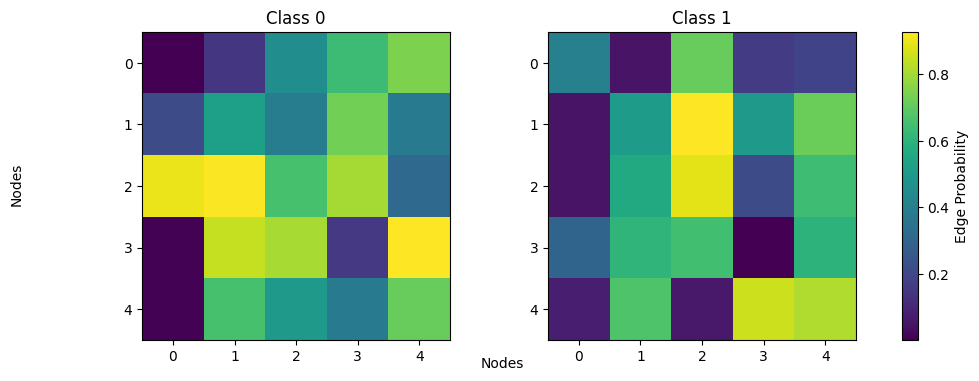

In [35]:
edge_probs_0 = generator_0_no_GED.AdjacencyMatrix.probs
edge_probs_0 = edge_probs_0.detach().cpu().numpy()

edge_probs_1 = generator_1_no_GED.AdjacencyMatrix.probs
edge_probs_1 = edge_probs_1.detach().cpu().numpy()

# edge_probs_untrained = generator_untrained.AdjacencyMatrix.probs
# edge_probs_untrained = edge_probs_untrained.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(edge_probs_0, cmap='viridis', interpolation='nearest')
im1 = axes[1].imshow(edge_probs_1, cmap='viridis', interpolation='nearest')
# im2 = axes[2].imshow(edge_probs_untrained, cmap='viridis', interpolation='nearest')

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes.ravel().tolist())
cbar.set_label('Edge Probability')

# Set titles
axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
# axes[2].set_title('Untrained')

# Set common x and y labels
fig.text(0.45, 0.04, 'Nodes', ha='center')
fig.text(0.04, 0.5, 'Nodes', va='center', rotation='vertical')

plt.show()

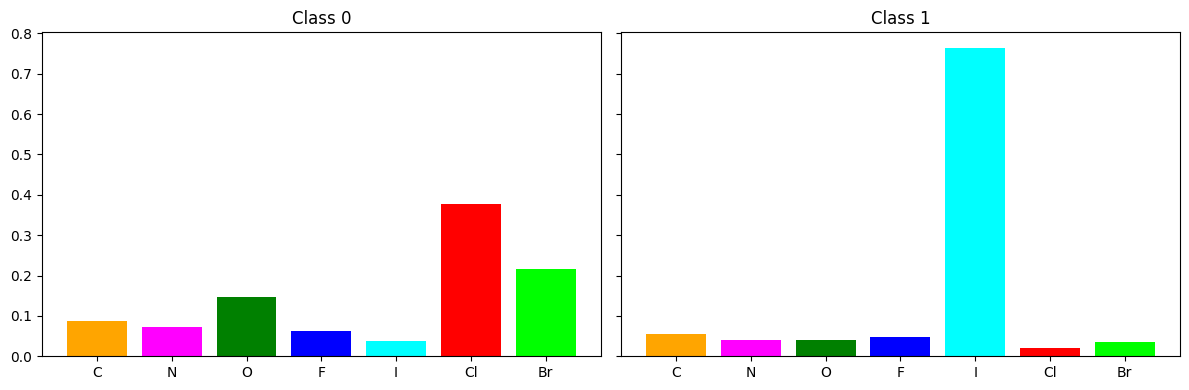

In [28]:
cell_type_probs_0 = torch.softmax(generator_0_no_GED.DisNodeFeats[0].probs, dim=0)
cell_type_probs_0 = cell_type_probs_0.detach().cpu().numpy()

cell_type_probs_1 = torch.softmax(generator_1_no_GED.DisNodeFeats[0].probs, dim=0)
cell_type_probs_1 = cell_type_probs_1.detach().cpu().numpy()

# cell_type_probs_untrained = torch.softmax(
#     generator_untrained.DisNodeFeats[0].probs, dim=0)
# cell_type_probs_untrained = cell_type_probs_untrained.detach().cpu().numpy()

plot_indices = node_types

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(plot_indices, cell_type_probs_0, color=color_palette)
axes[1].bar(plot_indices, cell_type_probs_1, color=color_palette)
#axes[2].bar(plot_indices, cell_type_probs_untrained, color=color_palette)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
#axes[2].set_title('Untrained')

plt.tight_layout()
plt.show()

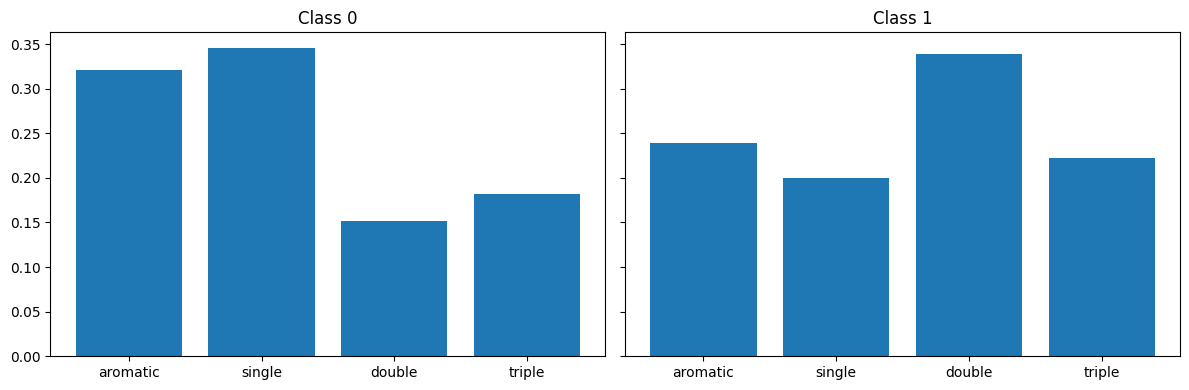

In [29]:
cell_type_probs_0 = torch.softmax(generator_0_no_GED.DisEdgeFeats[0].probs, dim=0)
cell_type_probs_0 = cell_type_probs_0.detach().cpu().numpy()

cell_type_probs_1 = torch.softmax(generator_1_no_GED.DisEdgeFeats[0].probs, dim=0)
cell_type_probs_1 = cell_type_probs_1.detach().cpu().numpy()

# cell_type_probs_untrained = torch.softmax(
#     generator_untrained.DisEdgeFeats[0].probs, dim=0)
# cell_type_probs_untrained = cell_type_probs_untrained.detach().cpu().numpy()

plot_indices = edge_types

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(plot_indices, cell_type_probs_0)
axes[1].bar(plot_indices, cell_type_probs_1)
# axes[2].bar(plot_indices, cell_type_probs_untrained)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
# axes[2].set_title('Untrained')

plt.tight_layout()
plt.show()

## Empirical Distribution

In [8]:
data_0 = train_data_list_0 + test_data_list_0
data_1 = train_data_list_1 + test_data_list_1

batch_0 = pyg.data.Batch.from_data_list(data_0)
batch_1 = pyg.data.Batch.from_data_list(data_1)

emp_dist_node_0 = batch_0.x.argmax(dim=-1).numpy()
emp_dist_node_1 = batch_1.x.argmax(dim=-1).numpy()

emp_dist_edge_0 = batch_0.edge_attr.argmax(dim=-1).numpy()
emp_dist_edge_1 = batch_1.edge_attr.argmax(dim=-1).numpy()

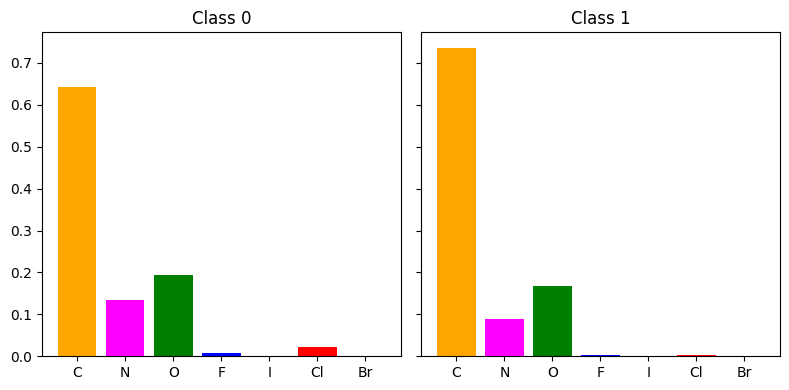

In [17]:
# Empirical node type probabilities
unique_classes_0, counts_0 = np.unique(emp_dist_node_0, return_counts=True)
percentages_0 = (counts_0 / len(emp_dist_node_0))
percentages_0 = np.insert(percentages_0, 4, 0.0) # missing I

unique_classes_1, counts_1 = np.unique(emp_dist_node_1, return_counts=True)
percentages_1 = (counts_1 / len(emp_dist_node_1))
percentages_1 = np.insert(percentages_1, 4, 0.0) # missing I

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axes[0].bar(node_types, percentages_0, color=color_palette)
axes[1].bar(node_types, percentages_1, color=color_palette)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')

plt.tight_layout()
plt.show()

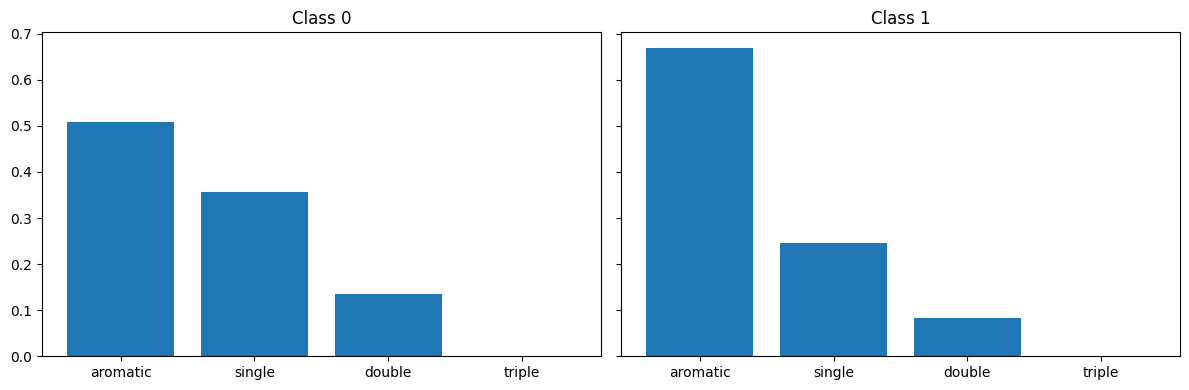

In [18]:
# Empirical edge type probabilities
unique_classes_0, counts_0 = np.unique(emp_dist_edge_0, return_counts=True)
percentages_0 = (counts_0 / len(emp_dist_edge_0))
percentages_0 = np.insert(percentages_0, 3, 0.0) # no triples. 

unique_classes_1, counts_1 = np.unique(emp_dist_edge_1, return_counts=True)
percentages_1 = (counts_1 / len(emp_dist_edge_1))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(edge_types, percentages_0)
axes[1].bar(edge_types, percentages_1)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')

plt.tight_layout()
plt.show()